# Logistic Model

# Load Pacakage.

In [1]:
import re
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import plotly.express as px
import os
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
file=os.path.dirname(os.getcwd())
Clean_DF = pd.read_csv(file+'\\data\\Steam_Clean_Data.csv')
Train_reco = pd.read_csv(file+'\\data\\Train_reco.csv')
Test_reco = pd.read_csv(file+'\\data\\Test_reco.csv')
Train_auth = pd.read_csv(file+'\\data\\Train_auth.csv')
Test_auth = pd.read_csv(file+'\\data\\Test_auth.csv')

## Transform Recomendation Data.

Use tfidvectorizer to transform text data

In [3]:
Tfidf_reco=TfidfVectorizer(
    input="content",
    lowercase=True, 
    stop_words = "english",max_features = 1000)
Train_DTM_reco = Tfidf_reco.fit_transform(Train_reco['review'])
Test_DTM_reco = Tfidf_reco.transform(Test_reco['review'])

Convert tfidvectorizer result to pandas data frame.

In [4]:
Train_DTM_DF_reco=pd.DataFrame(Train_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
Test_DTM_DF_reco=pd.DataFrame(Test_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())

## Recommendation Model

Set an instantiate logistic model

In [5]:
## Instantiate
log_reco=LogisticRegression(random_state=5)


Use trran data to fit the model.

In [6]:
log_reco.fit(Train_DTM_DF_reco, Train_reco['recommendation'])

LogisticRegression(random_state=5)

Predict the test data

In [7]:
DT_pred_reco=log_reco.predict(Test_DTM_DF_reco)

Create a confusion matrix


The confusion matrix is:
[[19211  8410]
 [ 5176 51019]]


0.8379068435620883

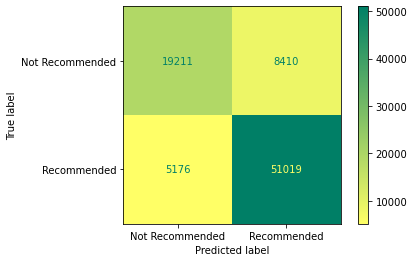

In [8]:
bn_matrix = confusion_matrix(Test_reco['recommendation'], DT_pred_reco)
print("\nThe confusion matrix is:")
print(bn_matrix)
plot_confusion_matrix(log_reco, Test_DTM_DF_reco, Test_reco['recommendation'], cmap = 'summer_r')
accuracy_score(Test_reco['recommendation'], DT_pred_reco)

Use cross valiadation to generate logistic model.

In [12]:
from sklearn.linear_model import LogisticRegressionCV
log_reco2 = LogisticRegressionCV(cv=10, random_state=0)
log_reco2.fit(Train_DTM_DF_reco, Train_reco['recommendation'])
DT_pred_reco2=log_reco2.predict(Test_DTM_DF_reco)

Create a confusion matrix.


The confusion matrix is:
[[19253  8368]
 [ 5220 50975]]


0.8378829817695905

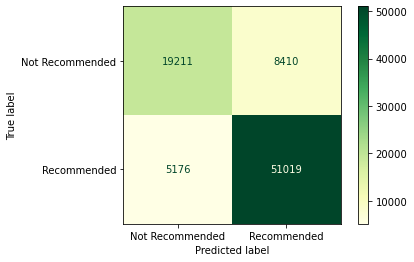

In [36]:
bn_matrix = confusion_matrix(Test_reco['recommendation'], DT_pred_reco2)
print("\nThe confusion matrix is:")
print(bn_matrix)
plot_confusion_matrix(log_reco, Test_DTM_DF_reco, Test_reco['recommendation'], cmap = 'YlGn')
#plt.savefig('MyTree1_cm.png')
accuracy_score(Test_reco['recommendation'], DT_pred_reco2)